In [1]:
import pandas as pd
import numpy as np

df_tesla = pd.read_csv('../models/merged_tweets.csv')
df_tesla["createdAt"] = pd.to_datetime(
    df_tesla["createdAt"],
    errors="coerce"
)

target_end = pd.to_datetime("2025-04-01").date()

# Step 3: Filter rows where the date matches
tweets_on_topic = df_tesla[(df_tesla['createdAt'].dt.date <= target_end)
 & (df_tesla['Topic'] == 1)]

# Optional: view results
# tweets_on_topic.head()


/var/folders/nf/2xng7w014d1f2mbbxqsxbwg40000gn/T/ipykernel_3566/3339277431.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_tesla["createdAt"] = pd.to_datetime(


In [2]:
import pytz
tweets_on_topic = tweets_on_topic[['Document', 'createdAt', 'Topic']]   
eastern = pytz.timezone("US/Eastern")
tweets_on_topic['createdAt'] = tweets_on_topic['createdAt'].dt.tz_convert(eastern)

In [3]:
# filter out tweets outside the time range of 04:00 to 17:59 (2 hour before market close)
tweets_on_topic = tweets_on_topic[
    tweets_on_topic["createdAt"].dt.time >= pd.to_datetime("04:00").time()
]
tweets_on_topic = tweets_on_topic[
    tweets_on_topic["createdAt"].dt.time <= pd.to_datetime("17:59").time()
]
# Step 1: Sort by time
tweets_on_topic = tweets_on_topic.sort_values("createdAt").reset_index(drop=True)

# Step 2: Compute time difference between each tweet and the previous one
tweets_on_topic["time_diff"] = tweets_on_topic["createdAt"].diff()

# Step 3: Mark where a new cluster/event should start (gap > 7 hours)
tweets_on_topic["new_event"] = tweets_on_topic["time_diff"] > pd.Timedelta(hours=7)

# Step 4: Create event_id by cumulatively summing new_event markers
tweets_on_topic["event_id"] = tweets_on_topic["new_event"].cumsum()

In [4]:
num_events = tweets_on_topic["event_id"].nunique()
print(f"Number of Tesla tweet-based events target days: {num_events}")

Number of Tesla tweet-based events target days: 121


In [5]:
event_dates = tweets_on_topic.groupby("event_id")["createdAt"].min().tolist()
#event_dates = [pd.Timestamp(d) for d in event_dates]
print(event_dates)


[Timestamp('2023-05-11 12:05:38-0400', tz='US/Eastern'), Timestamp('2023-06-03 15:42:53-0400', tz='US/Eastern'), Timestamp('2023-06-08 17:06:46-0400', tz='US/Eastern'), Timestamp('2023-07-15 05:02:46-0400', tz='US/Eastern'), Timestamp('2023-09-17 05:44:55-0400', tz='US/Eastern'), Timestamp('2023-10-03 12:04:11-0400', tz='US/Eastern'), Timestamp('2023-11-22 13:32:21-0500', tz='US/Eastern'), Timestamp('2023-12-05 06:00:07-0500', tz='US/Eastern'), Timestamp('2024-01-02 12:26:21-0500', tz='US/Eastern'), Timestamp('2024-01-08 17:56:27-0500', tz='US/Eastern'), Timestamp('2024-01-11 09:31:04-0500', tz='US/Eastern'), Timestamp('2024-02-02 05:56:59-0500', tz='US/Eastern'), Timestamp('2024-02-11 13:47:41-0500', tz='US/Eastern'), Timestamp('2024-02-16 13:22:09-0500', tz='US/Eastern'), Timestamp('2024-02-27 10:31:12-0500', tz='US/Eastern'), Timestamp('2024-03-04 17:18:32-0500', tz='US/Eastern'), Timestamp('2024-03-07 15:07:43-0500', tz='US/Eastern'), Timestamp('2024-03-12 16:13:41-0400', tz='US/Ea

In [7]:
df_price = pd.read_csv('../data/stocks/tsla_intraday_202305_202504-1m.csv', sep=",", skiprows=1)
df_price.columns = ["Datetime", "Open", "High", "Low", "Close", "Volume"]
df_price.columns
# Ensure Date is datetime 
df_price["Datetime"] = pd.to_datetime(df_price["Datetime"])
eastern = pytz.timezone("US/Eastern")
eastern = pytz.timezone("US/Eastern")
df_price["Datetime"] = pd.to_datetime(df_price["Datetime"]).dt.tz_localize(eastern)


# Sort by datetime
df_price = df_price.sort_values("Datetime").copy()

In [8]:
import pandas as pd
import numpy as np

df_price = df_price.set_index("Datetime")
# Convert index to datetime if not already
#df_price.index = pd.to_datetime(df_price.index)
print(df_price.index)

DatetimeIndex(['2023-05-01 04:01:00-04:00', '2023-05-01 04:03:00-04:00',
               '2023-05-01 04:04:00-04:00', '2023-05-01 04:05:00-04:00',
               '2023-05-01 04:06:00-04:00', '2023-05-01 04:07:00-04:00',
               '2023-05-01 04:08:00-04:00', '2023-05-01 04:09:00-04:00',
               '2023-05-01 04:10:00-04:00', '2023-05-01 04:11:00-04:00',
               ...
               '2025-04-30 19:50:00-04:00', '2025-04-30 19:51:00-04:00',
               '2025-04-30 19:52:00-04:00', '2025-04-30 19:53:00-04:00',
               '2025-04-30 19:54:00-04:00', '2025-04-30 19:55:00-04:00',
               '2025-04-30 19:56:00-04:00', '2025-04-30 19:57:00-04:00',
               '2025-04-30 19:58:00-04:00', '2025-04-30 19:59:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Datetime', length=479790, freq=None)


In [ ]:
import pandas as pd
import numpy as np

# Parameters
estimation_obs = 300  # last 5 hourly returns = 300 x 1 min intervals
post_event_obs = 120  # 2 hour after event = 120 x 1 min intervals
min_gap_between_events = estimation_obs + post_event_obs  # for spacing

# Ensure log returns are computed
df_price = df_price.sort_index()
df_price["log_return"] = np.log(df_price["Close"] / df_price["Close"].shift(1))

# Ensure event timestamps are sorted and valid
event_dates = sorted([pd.Timestamp(d) for d in event_dates])
valid_events = []
last_event_time = None

# Filter valid events by observation gaps, not just time
for date in event_dates:
    if last_event_time is None:
        valid_events.append(date)
        last_event_time = date
    else:
        # Only accept if date is at least N rows ahead in trading calendar
        prev_idx = df_price.index.get_indexer([last_event_time], method='nearest')[0]
        curr_idx = df_price.index.get_indexer([date], method='nearest')[0]
        if (curr_idx - prev_idx) >= min_gap_between_events:
            valid_events.append(date)
            last_event_time = date

# Run event study
event_results = []

for event_time in valid_events:
    try:
        # Align event_time to the nearest available trading timestamp
        if event_time not in df_price.index:
            future_times = df_price.index[df_price.index > event_time]
            if future_times.empty:
                continue
            event_time = future_times[0]

        event_idx = df_price.index.get_loc(event_time)

        # Get n prior observations as estimation window
        if event_idx < estimation_obs:
            print(f"Skipping {event_time} — not enough trading history")
            continue

        est_window = df_price.iloc[event_idx - estimation_obs : event_idx]
        expected_return = est_window["log_return"].mean()

        # Get next n observation as post-event
        post_event = df_price.iloc[event_idx : event_idx + post_event_obs + 1]
        if not all(post_event.index.normalize() == event_time.normalize()):
            print(f"⏭️ Skipping {event_time} — post-event window crosses to next day")
            continue
        for i, (t, row) in enumerate(post_event.iterrows()):
            actual_return = row["log_return"]
            abnormal_return = actual_return - expected_return

            event_results.append({
                "event_time": event_time,
                "min_offset": i,
                "timestamp": t,
                "actual_return": actual_return,
                "expected_return": expected_return,
                "abnormal_return": abnormal_return
            })

    except Exception as e:
        print(f"❌ Error at {event_time}: {e}")
        continue

# Final DataFrame
df_events = pd.DataFrame(event_results)}}


In [10]:
df_events

,event_time,min_offset,timestamp,actual_return,expected_return,abnormal_return
0,2023-05-11 12:06:00-04:00,0,2023-05-11 12:06:00-04:00,0.000336,0.000003,0.000334
1,2023-05-11 12:06:00-04:00,1,2023-05-11 12:07:00-04:00,0.000561,0.000003,0.000559
2,2023-05-11 12:06:00-04:00,2,2023-05-11 12:08:00-04:00,-0.000502,0.000003,-0.000505
3,2023-05-11 12:06:00-04:00,3,2023-05-11 12:09:00-04:00,-0.000325,0.000003,-0.000328
4,2023-05-11 12:06:00-04:00,4,2023-05-11 12:10:00-04:00,-0.001065,0.000003,-0.001068
...,...,...,...,...,...,...
14152,2025-03-31 11:18:00-04:00,116,2025-03-31 13:14:00-04:00,-0.001854,-0.000021,-0.001833
14153,2025-03-31 11:18:00-04:00,117,2025-03-31 13:15:00-04:00,-0.000176,-0.000021,-0.000155
14154,2025-03-31 11:18:00-04:00,118,2025-03-31 13:16:00-04:00,0.000137,-0.000021,0.000158
14155,2025-03-31 11:18:00-04:00,119,2025-03-31 13:17:00-04:00,-0.000377,-0.000021,-0.000356


In [45]:
from scipy import stats
minutes = np.arange(1, 121)  # 1 to 10 minutes

    # Format significance stars
def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''
        
def test_abnormal_returns(minute):
    results = []
    for m in minute:
        group = df_events[df_events["min_offset"] == m - 1]  # Adjust for zero-indexing
        ar_mean = group["abnormal_return"].mean()
        ar_std = group["abnormal_return"].std(ddof=1)
        n = group["abnormal_return"].count()

        # T-test
        t_stat, t_pval = stats.ttest_1samp(group["abnormal_return"], 0)

        results.append({
        "Minute": f"[{m}]",
        "AR": f"{ar_mean * 100:.4f} %",
        "t-test": f"{t_stat:.2f}{stars(t_pval)}",
        #"z-test": f"{z_stat:.2f}{stars(z_pval)}"
    })
    return results


# Create final DataFrame
df_test = pd.DataFrame(test_abnormal_returns(minutes))
df_test = df_test[df_test['t-test'].str.contains(r'\*', regex=True)]
df_test

,Minute,AR,t-test
5,[6],0.0320 %,2.52**
28,[29],-0.0261 %,-2.27**
29,[30],-0.0216 %,-1.78*
48,[49],-0.0230 %,-1.93*
65,[66],0.0184 %,2.29**
71,[72],-0.0281 %,-2.09**
73,[74],0.0197 %,2.05**
75,[76],-0.0227 %,-1.76*
87,[88],0.0260 %,2.78***
88,[89],-0.0170 %,-1.88*


Interpretation of test results: stock price reacts positively within the first 6 minutes after the tweet being published (t-value is positive), but after about half an hour it drops again. After that the price seems to stabalize but continues carrying on a downward trend.

In [46]:
import pandas as pd
import numpy as np

# Ensure log returns are computed
df_price = df_price.sort_index()
df_price["log_return"] = np.log(df_price["Close"] / df_price["Close"].shift(1))

# Ensure event timestamps are sorted and valid
event_dates = sorted([pd.Timestamp(d) for d in event_dates])
valid_events = []
last_event_time = None

# Filter valid events by observation gaps, not just time
for date in event_dates:
    if last_event_time is None:
        valid_events.append(date)
        last_event_time = date
    else:
        # Only accept if date is at least N rows ahead in trading calendar
        prev_idx = df_price.index.get_indexer([last_event_time], method='nearest')[0]
        curr_idx = df_price.index.get_indexer([date], method='nearest')[0]
        if (curr_idx - prev_idx) >= min_gap_between_events:
            valid_events.append(date)
            last_event_time = date

# Run event study
pre_post_event_results = []

for event_time in valid_events:
    try:
        # if event_time.time() < pd.to_datetime("09:30").time():
             # Skip tweets before market open
        #     continue
        # Align event_time to the nearest available trading timestamp
        if event_time not in df_price.index:
            future_times = df_price.index[df_price.index > event_time]
            if future_times.empty:
                continue
            event_time = future_times[0]

        event_idx = df_price.index.get_loc(event_time)

        # Get 6 prior observations as estimation window
        if event_idx < estimation_obs:
            print(f"Skipping {event_time} — not enough trading history")
            continue

        est_window = df_price.iloc[event_idx - estimation_obs - estimation_obs : event_idx]
        expected_return = est_window["log_return"].mean()

        # Get next n observation as post-event
        post_event = df_price.iloc[event_idx - estimation_obs : event_idx + post_event_obs + 1]
        if not all(post_event.index.normalize() == event_time.normalize()):
            print(f"⏭️ Skipping {event_time} — post-event window crosses to next day")
            continue
        for i, (t, row) in enumerate(post_event.iterrows()):
            offset = i - estimation_obs  # this shifts the index so tweet = 0
            actual_return = row["log_return"]
            abnormal_return = actual_return - expected_return

            pre_post_event_results.append({
                "event_time": event_time,
                "min_offset": offset,
                "timestamp": t,
                "actual_return": actual_return,
                "expected_return": expected_return,
                "abnormal_return": abnormal_return
            })

    except Exception as e:
        print(f"❌ Error at {event_time}: {e}")
        continue

# Final DataFrame
df_pre_post = pd.DataFrame(pre_post_event_results)


⏭️ Skipping 2023-06-05 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2023-07-17 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2023-09-18 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2023-12-05 06:01:00-05:00 — post-event window crosses to next day
⏭️ Skipping 2024-02-02 05:57:00-05:00 — post-event window crosses to next day
⏭️ Skipping 2024-02-12 04:00:00-05:00 — post-event window crosses to next day
⏭️ Skipping 2024-04-01 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-05-07 04:43:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-05-16 05:38:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-06-10 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-07-09 06:29:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-07-22 04:00:00-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-08-05 04:00:00-04:00 — post-event window crosse

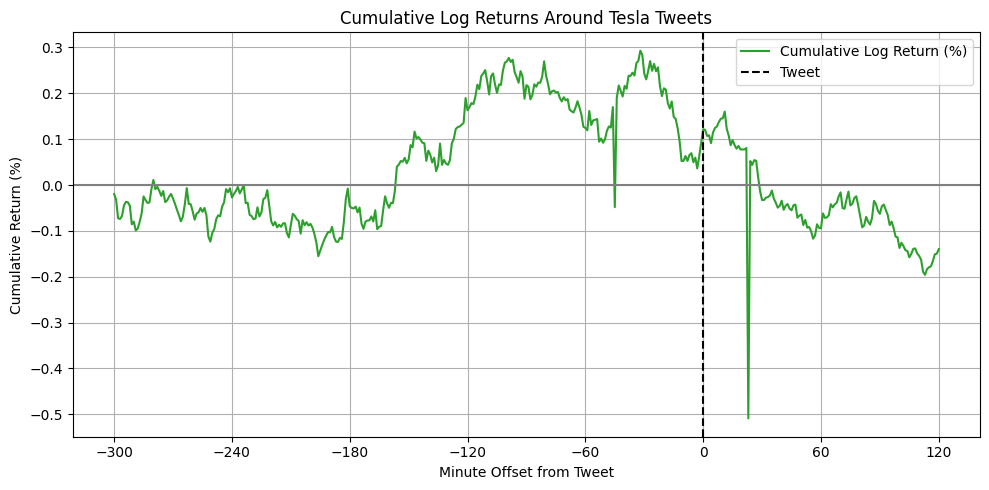

In [47]:
import matplotlib.pyplot as plt

# 1. Aggregate by minute offset: take mean log return across all events
mean_returns = df_pre_post.groupby("min_offset")["actual_return"].mean()

# 2. Compute cumulative log return (this is additive)
cumulative_return = mean_returns.cumsum()

# 3. Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return.index, cumulative_return.values * 100, label="Cumulative Log Return (%)", color="tab:green")
plt.axvline(0, linestyle="--", color="black", label="Tweet")
plt.axhline(0, linestyle="-", color="gray")
plt.title("Cumulative Log Returns Around Tesla Tweets")
plt.xlabel("Minute Offset from Tweet")
plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Tweets seem to be published 30 minutes after the stock price experiences a sharp decrease. Around the time of publishment price slightly recovers and continues to increase within about 10 minutes. Then the price goes down again. 


In [15]:
df_price["log_volume"] = np.log(df_price["Volume"]+1)  # Avoid log(0)

volume_results = []

for tweet_time in valid_events:
    try:
        # Align tweet to next available stock timestamp
        if tweet_time not in df_price.index:
            future_times = df_price.index[df_price.index > tweet_time]
            if future_times.empty:
                continue
            aligned_time = future_times[0]
        else:
            aligned_time = tweet_time

        event_idx = df_price.index.get_loc(aligned_time)

        # Check for sufficient history
        if event_idx < estimation_obs:
            continue

        # Estimation window
        est_window = df_price.iloc[event_idx - estimation_obs : event_idx]
        expected_volume = est_window["log_volume"].mean()

        # Post-event window
        post_event = df_price.iloc[event_idx : event_idx + post_event_obs + 1]
        if not all(post_event.index.normalize() == tweet_time.normalize()):
            print(f"⏭️ Skipping {tweet_time} — post-event window crosses to next day")
            continue
        
        for i, (t, row) in enumerate(post_event.iterrows()):
            actual_volume = row["log_volume"]
            abnormal_volume = actual_volume - expected_volume

            volume_results.append({
                "tweet_time": tweet_time,
                "aligned_price_time": aligned_time,
                "min_offset": i,
                "timestamp": t,
                "actual_volume": actual_volume,
                "expected_volume": expected_volume,
                "abnormal_volume": abnormal_volume
            })

    except Exception as e:
        print(f"Error at {tweet_time}: {e}")
        continue

# Final volume DataFrame
df_volume_events = pd.DataFrame(volume_results)


⏭️ Skipping 2023-06-03 15:42:53-04:00 — post-event window crosses to next day
⏭️ Skipping 2023-07-15 05:02:46-04:00 — post-event window crosses to next day
⏭️ Skipping 2023-09-17 05:44:55-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-02-11 13:47:41-05:00 — post-event window crosses to next day
⏭️ Skipping 2024-03-29 16:28:57-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-06-09 16:31:09-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-07-20 11:39:31-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-08-03 13:00:42-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-09-02 12:08:51-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-09-21 05:33:59-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-09-28 08:59:21-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-10-06 10:38:22-04:00 — post-event window crosses to next day
⏭️ Skipping 2024-10-13 11:03:55-04:00 — post-event window crosse

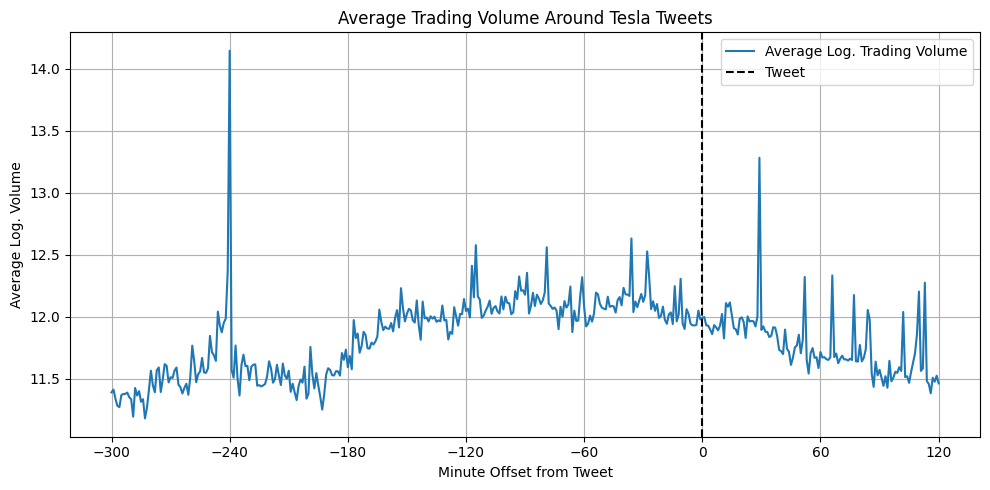

In [16]:
import matplotlib.pyplot as plt

volume_aligned = []

for tweet_time in valid_events:
    try:
        if tweet_time.time() < pd.to_datetime("09:30").time():
            # Skip tweets before market open
            continue
        # Align tweet time to next available trading timestamp
        if tweet_time not in df_price.index:
            future_times = df_price.index[df_price.index > tweet_time]
            if future_times.empty:
                continue
            aligned_time = future_times[0]
        else:
            aligned_time = tweet_time

        event_idx = df_price.index.get_loc(aligned_time)

        # Ensure enough data before and after
        if event_idx < estimation_obs or event_idx + post_event_obs >= len(df_price):
            continue

        # Extract volume window
        window = df_price.iloc[event_idx - estimation_obs : event_idx + post_event_obs + 1].copy()
        window["min_offset"] = range(-estimation_obs, post_event_obs + 1)
        window["tweet_time"] = tweet_time

        volume_aligned.append(window[["tweet_time", "min_offset", "Volume"]])

    except Exception as e:
        print(f"Error at {tweet_time}: {e}")
        continue

# Combine all event windows
df_volume_all = pd.concat(volume_aligned)

# Compute average actual volume by minute offset
mean_volume = df_volume_all.groupby("min_offset")["Volume"].mean()
# Clip outliers .
# 1. remove top 1% of volume
# q99 = df_volume_all["Volume"].quantile(0.99)
# df_volume_all_clipped = df_volume_all[df_volume_all["Volume"] < q99]
# 2. remove outliers beyond 3 standard deviations
mean_vol = df_volume_all["Volume"].mean()
std_vol = df_volume_all["Volume"].std()
threshold = mean_vol + 3 * std_vol
df_volume_cleaned = df_volume_all[df_volume_all["Volume"] <= threshold]  
df_outliers = df_volume_all[df_volume_all["Volume"] > threshold]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mean_volume.index, np.log(mean_volume.values), label="Average Log. Trading Volume", color="tab:blue")
# plt.yscale("log")
plt.axvline(0, color="black", linestyle="--", label="Tweet")
plt.title("Average Trading Volume Around Tesla Tweets")
plt.xlabel("Minute Offset from Tweet")
plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
plt.ylabel("Average Log. Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
from scipy import stats
import numpy as np

# Define windows in minutes
windows = [(0, 1), (0, 2), (0, 5), (0, 10), (0, 30), (0, 60), (0, 120)]

results = []
def stars(p):
        if p < 0.01:
            return '***'
        elif p < 0.05:
            return '**'
        elif p < 0.1:
            return '*'
        else:
            return ''
# Calculate CATV and t-test for each window
for start, end in windows:
    window_df = df_volume_events[(df_volume_events["min_offset"] >= start) & (df_volume_events["min_offset"] <= end)]

    # Group by event_time and sum abnormal_volume within the window (CATV)
    catv_per_event = window_df.groupby("tweet_time")["abnormal_volume"].sum()

    # Mean CATV
    catv_mean = catv_per_event.mean()

    # Perform t-test: is CATV significantly different from 0
    t_stat, p_value = stats.ttest_1samp(catv_per_event, 0)
    
    results.append({
        "Window": f"[{start}, {end}]",
        "CATV": round(catv_mean, 3),
        "t-stat": f"{round(t_stat, 2)} {stars(p_value)}"
    })

df_vol_results = pd.DataFrame(results)
df_vol_results
#import ace_tools as tools; tools.display_dataframe_to_user(name="CATV by Time Window", dataframe=df_results)


,Window,CATV,t-stat
0,"[0, 1]",1.368,3.52 ***
1,"[0, 2]",2.072,3.64 ***
2,"[0, 5]",4.008,3.55 ***
3,"[0, 10]",7.515,3.65 ***
4,"[0, 30]",19.727,3.34 ***
5,"[0, 60]",36.931,3.19 ***
6,"[0, 120]",63.097,2.58 **


In [18]:
results = []
for start, end in windows:
    window_df = df_events[(df_events["min_offset"] >= start) & (df_events["min_offset"] <= end)]

    # Group by event_time and sum abnormal_volume within the window (CATV)
    catv_per_event = window_df.groupby("event_time")["abnormal_return"].sum()

    # Mean CAR
    catv_mean = catv_per_event.mean()

    # Perform t-test: is CATV significantly different from 0
    t_stat, p_value = stats.ttest_1samp(catv_per_event, 0)
    
    results.append({
        "Window": f"[{start}, {end}]",
        "CAR": f"{catv_mean * 100:.4f} %",
        "t-stat": f"{round(t_stat, 2)} {stars(p_value)}"
    })
df_return_results = pd.DataFrame(results)
df_return_results

,Window,CAR,t-stat
0,"[0, 1]",0.0116 %,0.1
1,"[0, 2]",0.0216 %,0.2
2,"[0, 5]",0.0745 %,0.7
3,"[0, 10]",0.1157 %,1.04
4,"[0, 30]",0.0130 %,0.09
5,"[0, 60]",-0.1099 %,-0.74
6,"[0, 120]",-0.1521 %,-0.82


In [19]:
print(threshold)
df_outliers

1248137.76858345


,tweet_time,min_offset,Volume
Datetime,,,
2023-06-02 16:00:00-04:00,2023-06-03 15:42:53-04:00,-240,5098242
2023-06-08 16:00:00-04:00,2023-06-08 17:06:46-04:00,-67,4475215
2023-11-22 09:30:00-05:00,2023-11-22 13:32:21-05:00,-243,1370568
2023-11-22 09:31:00-05:00,2023-11-22 13:32:21-05:00,-242,1318405
2024-01-02 09:30:00-05:00,2024-01-02 12:26:21-05:00,-177,1452046
...,...,...,...
2025-03-27 09:30:00-04:00,2025-03-27 12:32:37-04:00,-183,1327862
2025-03-27 09:31:00-04:00,2025-03-27 12:32:37-04:00,-182,1315503
2025-03-31 09:30:00-04:00,2025-03-31 11:17:23-04:00,-108,2204447
